In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline


In [5]:
train_data = pd.read_csv("fashion-mnist_train.csv")
test_data = pd.read_csv("fashion-mnist_test.csv")

In [6]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


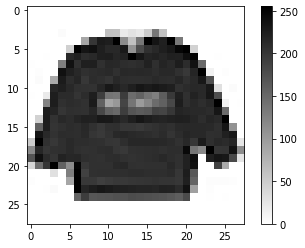

In [7]:
img=train_data.iloc[0:1,1:]
img=np.array(img)

img=np.reshape(img,(28,28,1))
plt.imshow(img,cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
x_train, y_train = train_data.drop(["label"],axis=1), train_data["label"] 
x_test, y_test = test_data.drop(["label"],axis=1), test_data["label"] 

In [9]:
x_train = (x_train / 255).astype("float32").to_numpy()
x_test = (x_test / 255).astype("float32").to_numpy()

y_train = pd.get_dummies(train_data['label'],drop_first=True).to_numpy()
y_test = pd.get_dummies(test_data['label'],drop_first=True).to_numpy()

In [10]:
x_train.shape

(60000, 784)

In [32]:
class AdamOptimizer:
    def __init__(self, sizes, epochs, learning_rate):
            self.sizes = sizes
            self.epochs = epochs
            self.learning_rate = learning_rate
            self.l1_m = 0
            self.l2_m = 0
            self.l3_m = 0
            self.l1_v = 0
            self.l2_v = 0
            self.l3_v = 0
            self.b1 = 0.9
            self.b2 = 0.99
            self.epsilon = 10e-8
            input_layer=self.sizes[0]
            hidden_1=self.sizes[1]
            hidden_2=self.sizes[2]
            output_layer=self.sizes[3]
            self.w0 = np.random.normal(0.0, 0.1, (input_layer, hidden_1))
            self.w1 = np.random.normal(0.0, 0.1, (hidden_1, hidden_2))
            self.w2 = np.random.normal(0.0, 0.1, (hidden_2, output_layer))            
    
    def run(self, x_train, y_train, iteration, optimizer="adam"):
        # forward pass
        self.l0 = x_train
        self.l1 = self.sigmoid(np.dot(self.l0, self.w0))
        self.l2 = self.sigmoid(np.dot(self.l1, self.w1))
        self.l3 = self.softmax(np.dot(self.l2, self.w2))
        
        # backward pass
        self.l3_error = self.l3 - y_train
        self.l3_delta = self.l3_error * self.sigmoid(self.l3, derivative=True)
        self.l2_error = self.l3_delta.dot(self.w2.T)
        self.l2_delta = self.l2_error * self.sigmoid(self.l2, derivative=True)
        self.l1_error = self.l2_delta.dot(self.w1.T)
        self.l1_delta = self.l1_error * self.sigmoid(self.l1, derivative=True)
        
        change_w = {}
        
        if optimizer == "SGD":
            self.w2 -= (self.learning_rate * self.l2.T.dot(self.l3_delta))
            self.w1 -= (self.learning_rate * self.l1.T.dot(self.l2_delta))
            self.w0 -= (self.learning_rate * self.l0.T.dot(self.l1_delta))
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w
        
        if optimizer == "adam":
            #gradient calculation
            g2 = self.l2.T.dot(self.l3_delta)
            g1 = self.l1.T.dot(self.l2_delta)
            g0 = self.l0.T.dot(self.l1_delta)

            # calculating momentum
            self.l3_m = (self.l3_m*self.b1) + ((1 - self.b1)*g2)
            self.l2_m = (self.l2_m*self.b1) + ((1 - self.b1)*g1)
            self.l1_m = (self.l1_m*self.b1) + ((1 - self.b1)*g0)

            self.l3_v = (self.l3_v*self.b2) + ((1 - self.b2)*(g2**2))
            self.l2_v = (self.l2_v*self.b2) + ((1 - self.b2)*(g1**2))
            self.l1_v = (self.l1_v*self.b2) + ((1 - self.b2)*(g0**2))

            # calculating momentum hats
            l3_mhat = self.l3_m / (1 - (self.b1**iteration))
            l2_mhat = self.l2_m / (1 - (self.b1**iteration))
            l1_mhat = self.l1_m / (1 - (self.b1**iteration))

            l3_vhat = self.l3_v / (1 - (self.b2**iteration))
            l2_vhat = self.l2_v / (1 - (self.b2**iteration))
            l1_vhat = self.l1_v / (1 - (self.b2**iteration))

            # updating weights
            w3_change = l3_mhat / (np.sqrt(l3_vhat) + self.epsilon)
            w2_change = l2_mhat / (np.sqrt(l2_vhat) + self.epsilon)
            w1_change = l1_mhat / (np.sqrt(l1_vhat) + self.epsilon)
            
            self.w2 = self.w2 - (self.learning_rate * w3_change)
            self.w1 = self.w1 - (self.learning_rate * w2_change)
            self.w0 = self.w0 - (self.learning_rate * w1_change)
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w
        
        if optimizer == "nadam":
            # gradient calculation
            g2 = self.l2.T.dot(self.l3_delta)
            g1 = self.l1.T.dot(self.l2_delta)
            g0 = self.l0.T.dot(self.l1_delta)
            
            # calculating momentum
            self.l3_m = (self.l3_m*self.b1) + ((1 - self.b1)*g2)
            self.l2_m = (self.l2_m*self.b1) + ((1 - self.b1)*g1)
            self.l1_m = (self.l1_m*self.b1) + ((1 - self.b1)*g0)

            self.l3_v = (self.l3_v*self.b2) + ((1 - self.b2)*(g2**2))
            self.l2_v = (self.l2_v*self.b2) + ((1 - self.b2)*(g1**2))
            self.l1_v = (self.l1_v*self.b2) + ((1 - self.b2)*(g0**2))            

            # calculating momentum hats
            l3_mhat = (self.l3_m / (1 - (self.b1**iteration))) + ((1 - self.b1) * g2 / (1 - (self.b1**iteration)))
            l2_mhat = (self.l2_m / (1 - (self.b1**iteration))) + ((1 - self.b1) * g1 / (1 - (self.b1**iteration)))
            l1_mhat = (self.l1_m / (1 - (self.b1**iteration))) + ((1 - self.b1) * g0 / (1 - (self.b1**iteration)))

            l3_vhat = self.l3_v / (1 - (self.b2**iteration))
            l2_vhat = self.l2_v / (1 - (self.b2**iteration))
            l1_vhat = self.l1_v / (1 - (self.b2**iteration))

            # updating weights
            w3_change = l3_mhat / (np.sqrt(l3_vhat) + self.epsilon)
            w2_change = l2_mhat / (np.sqrt(l2_vhat) + self.epsilon)
            w1_change = l1_mhat / (np.sqrt(l1_vhat) + self.epsilon)
            
            self.w2 = self.w2 - (self.learning_rate * w3_change)
            self.w1 = self.w1 - (self.learning_rate * w2_change)
            self.w0 = self.w0 - (self.learning_rate * w1_change)
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w
        
        if optimizer == "rms":
            # gradient calculation
            g2 = self.l2.T.dot(self.l3_delta)
            g1 = self.l1.T.dot(self.l2_delta)
            g0 = self.l0.T.dot(self.l1_delta)
 
            # calculating momentum
            self.l3_m = (self.l3_m*self.b1) + ((1 - self.b1)*(g2 ** 2))
            self.l2_m = (self.l2_m*self.b1) + ((1 - self.b1)*(g1 ** 2))
            self.l1_m = (self.l1_m*self.b1) + ((1 - self.b1)*(g0 ** 2))
            
            # updating weights
            w3_change = g2 / (np.sqrt(self.l3_m + self.epsilon))
            w2_change = g1 / (np.sqrt(self.l2_m + self.epsilon))
            w1_change = g0 / (np.sqrt(self.l1_m + self.epsilon))
            
            self.w2 = self.w2 - (self.learning_rate * w3_change)
            self.w1 = self.w1 - (self.learning_rate * w2_change)
            self.w0 = self.w0 - (self.learning_rate * w1_change)
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w
        
        if optimizer == "gd_momentum":
            # gradient calculation
            g2 = self.l2.T.dot(self.l3_delta)
            g1 = self.l1.T.dot(self.l2_delta)
            g0 = self.l0.T.dot(self.l1_delta)
            
            # calculating momentum
            self.l3_m = (self.l3_m*self.b1) + (self.learning_rate*g2)
            self.l2_m = (self.l2_m*self.b1) + (self.learning_rate*g1)
            self.l1_m = (self.l1_m*self.b1) + (self.learning_rate*g0)
            
            # updating weights
            self.w2 = self.w2 - self.l3_m
            self.w1 = self.w1 - self.l2_m
            self.w0 = self.w0 - self.l1_m
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w
        
        if optimizer == "gd_nestrov":
            # gradient calculation
            g2 = self.l2.T.dot(self.l3_delta)
            g1 = self.l1.T.dot(self.l2_delta)
            g0 = self.l0.T.dot(self.l1_delta)
            
            # calculating nestrov momentum
            self.l3_m = (self.l3_m*self.b1) - self.learning_rate*g2
            self.l2_m = (self.l2_m*self.b1) - self.learning_rate*g1
            self.l1_m = (self.l1_m*self.b1) - self.learning_rate*g0
            
            # updating weights
            self.w2 = self.w2 + self.l3_m
            self.w1 = self.w1 + self.l2_m
            self.w0 = self.w0 + self.l1_m
            change_w["w2"] = self.w2
            change_w["w1"] = self.w1
            change_w["w0"] = self.w0
            return change_w           
            
            
            
            
    def forward_pass(self, x_train):
            # input layer activations becomes sample
            l0 = x_train #60000, 784
            # input layer to hidden layer 1
            l0_d = np.dot( l0, self.w0) #
            out1 = self.sigmoid(l0_d)
            # hidden layer 1 to hidden layer 2
            l1_d = np.dot(out1, self.w1)
            out2 = self.sigmoid(l1_d)
            # hidden layer 2 to output layer
            l2_d = np.dot(out2, self.w2)
            out3 = self.softmax(l2_d)
            return out3
    
    # Same as forward pass
    def get_l3(self, x_train):
        l0 = x_train
        l1 = self.sigmoid(np.dot(l0, self.w0))
        l2 = self.sigmoid(np.dot(l1, self.w1))
        l3 = self.softmax(np.dot(l2, self.w2))
        return l3
    
    def MSEloss(self, y, Y):
        return np.mean((y-Y)**2)
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)
   
    def predict(self, x, y):
        predictions = []
        output = self.get_l3(x)

        for i,j in zip(output,y):
            y_pred = np.argmax(i)
            predictions.append(y_pred==np.argmax(j))
        print(np.mean(predictions)) 
    
    def compute_accuracy(self, x_val, y_val):
        predictions = []
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val, optimizer="adam"):
        start_time = time.time()
        if optimizer == "adam":
            print("Using adam optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train, y_train, iteration+1, optimizer="adam")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
        if optimizer == "SGD":
            print("Using SGD optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train,y_train,iteration+1,optimizer="SGD")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
        if optimizer == "nadam":
            print("Using nadam optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train, y_train, iteration+1, optimizer="nadam")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
        if optimizer == "rms":
            print("Using rms optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train, y_train, iteration+1, optimizer="rms")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
        if optimizer == "gd_momentum":
            print("Using GDmomentum optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train, y_train, iteration+1, optimizer="gd_momentum")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
        if optimizer == "gd_nestrov":
            print("Using GDnestrov optimizer")
            for iteration in range(self.epochs):
                change_w = self.run(x_train, y_train, iteration+1, optimizer="gd_nestrov")
                l3 = self.get_l3(x_train)
                l = self.MSEloss(l3, y_train)
                print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(iteration+1, time.time() - start_time, l ))
            self.predict(x_test, y_test)
    


In [45]:
dnn = AdamOptimizer(sizes=[x_train.shape[1], 128, 128, 9], epochs=20, learning_rate=0.001)

In [46]:
dnn.train(x_train, y_train, x_test, y_test, optimizer="adam")


Using adam optimizer
Epoch: 1, Time Spent: 1.69s, Loss: 0.09999660456834393
Epoch: 2, Time Spent: 3.45s, Loss: 0.09999656041022126
Epoch: 3, Time Spent: 5.27s, Loss: 0.09999651946830336
Epoch: 4, Time Spent: 7.01s, Loss: 0.09999648255907984
Epoch: 5, Time Spent: 8.74s, Loss: 0.09999645018638431
Epoch: 6, Time Spent: 10.51s, Loss: 0.0999964225593269
Epoch: 7, Time Spent: 12.16s, Loss: 0.09999639963643085
Epoch: 8, Time Spent: 13.93s, Loss: 0.0999963811789091
Epoch: 9, Time Spent: 15.70s, Loss: 0.09999636681427536
Epoch: 10, Time Spent: 17.43s, Loss: 0.09999635610294871
Epoch: 11, Time Spent: 19.32s, Loss: 0.09999634858969511
Epoch: 12, Time Spent: 21.03s, Loss: 0.09999634383365809
Epoch: 13, Time Spent: 22.83s, Loss: 0.09999634142280657
Epoch: 14, Time Spent: 24.72s, Loss: 0.09999634097841265
Epoch: 15, Time Spent: 26.77s, Loss: 0.09999634215442361
Epoch: 16, Time Spent: 28.73s, Loss: 0.09999634463546009
Epoch: 17, Time Spent: 30.67s, Loss: 0.09999634813451033
Epoch: 18, Time Spent: 32.

In [24]:
pred = dnn.predict(x_test, y_test)

(10000, 9)
0.0
